Hello! This notebook just pulls the data and has some basic plots to start out. It also has info about what I've learned about Time Series (https://otexts.com/fpp3/intro.html) applied to our project (Please correct me if I'm wrong about anything and feel free to add code).

In [445]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_absolute_error

In [446]:
# Get tickers we are interested in
tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA'] # common etfs (https://www.bankrate.com/investing/best-index-funds/#NASDX)
test_tickers = ['BTC-USD']
NUM_TICKERS = len(tickers)

# Set start and end dates that specify the amount of data we will pull
START_DATE = '2014-01-01'
END_DATE = '2024-03-01'

# Pull data using API
data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [447]:
# TEMP
data = data.dropna()

In [448]:
# Checking for null values
data.isna().sum()

Ticker
DIA      0
NASDX    0
QQQ      0
SPY      0
VOO      0
dtype: int64

NA values were left in because we are just doing EDA right now


In [449]:
# Get data into long format so we can visualize it
long_data = pd.melt(data.reset_index(), id_vars = ['Date'], value_vars = tickers)

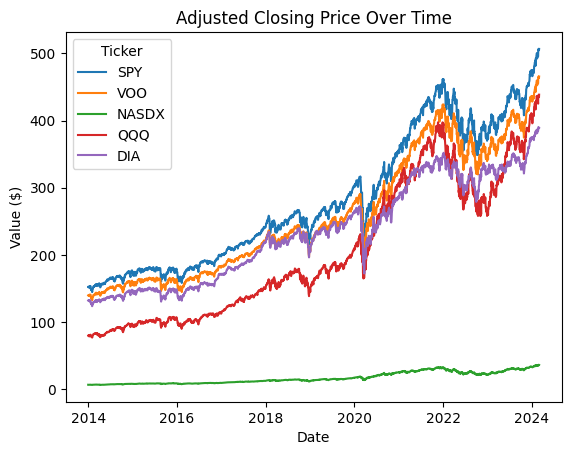

In [450]:
# Time Series Plots
sns.lineplot(data = long_data, x = 'Date', y = 'value', hue = 'Ticker');
plt.title('Adjusted Closing Price Over Time');
plt.ylabel('Value ($)');

How does this compare to Bitcoin and Coinbase?

In [451]:
crypto_equities_tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA', 'BTC', 'COIN'] 

crypto_equities = yf.download(crypto_equities_tickers, start=START_DATE, end=END_DATE)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


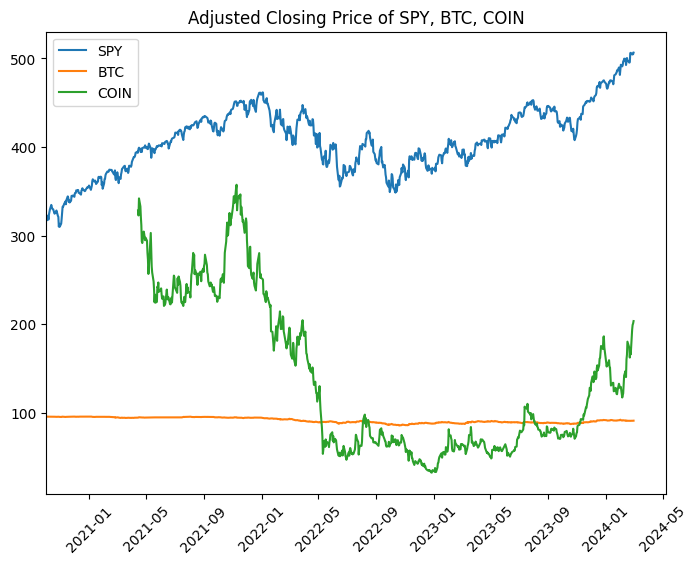

In [452]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(crypto_equities['SPY']);
ax.plot(crypto_equities['BTC']);
ax.plot(crypto_equities['COIN']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
plt.xlim(datetime(2020, 10, 1), date.today());
plt.xticks(rotation = 45);
ax.legend(labels = ['SPY', 'BTC', 'COIN'], loc = 'upper left');

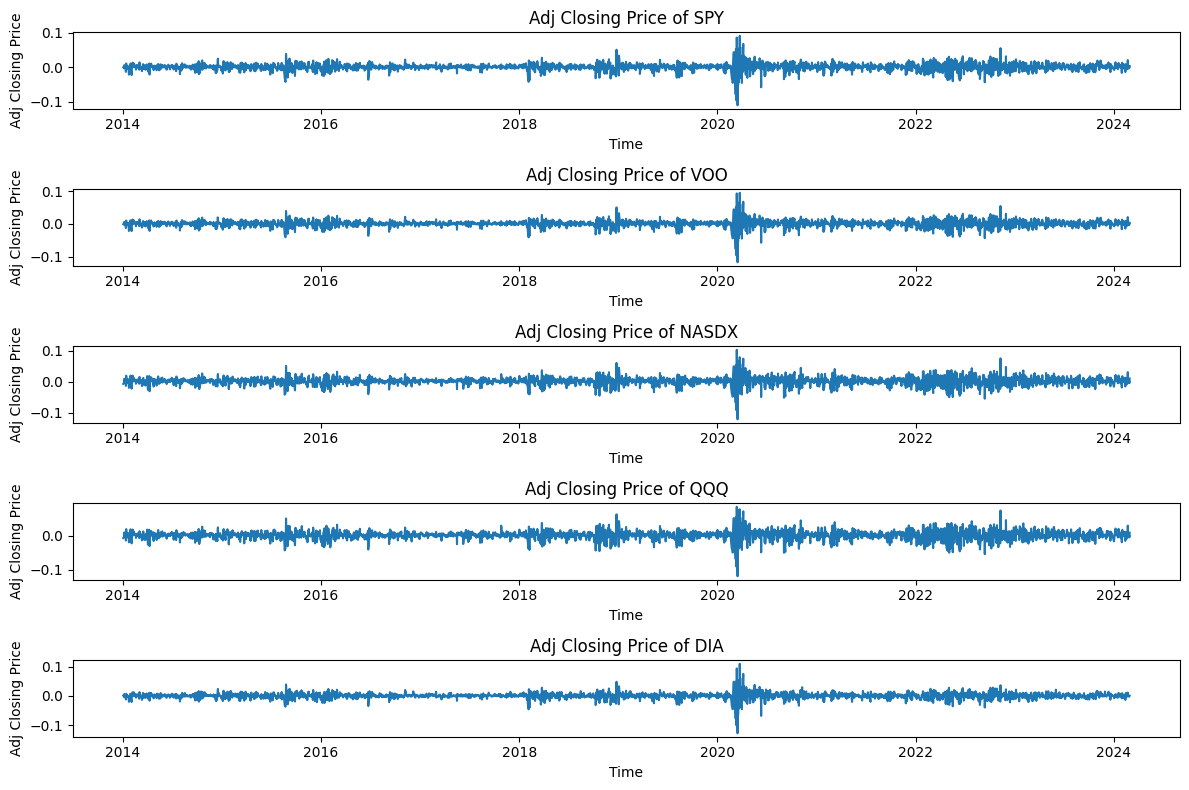

In [453]:
# pct change plot
fig, ax = plt.subplots(NUM_TICKERS, 1, figsize = (12,8))

for i, ticker in enumerate(tickers):
  sns.lineplot(data = long_data[long_data['Ticker'] == ticker], x = 'Date',
    y = long_data[long_data['Ticker'] == ticker]['value'].pct_change(), ax = ax[i]);

  ax[i].set(title = f'Adj Closing Price of {ticker}', xlabel = 'Time', ylabel= 'Adj Closing Price')

plt.tight_layout()


In [454]:
def seasonal_plot(df, ticker, ax = None, period = None):
  """input your data, ticker, and axis (optional). Outputs a seasonal plot of the ticker by month and year"""
  ticker_data = df[df['Ticker'] == ticker]

  if period == 'month':
    sns.lineplot(data = ticker_data, x = ticker_data['Date'].dt.month_name(), y = ticker_data['value'], hue = ticker_data['Date'].dt.year,
                palette = 'tab20', ax = ax);
  else:
    sns.lineplot(data = ticker_data, x = ticker_data['Date'], y = ticker_data['value'], hue = ticker_data['Date'].dt.year,
                palette = 'tab20', ax = ax);


  plt.xticks(rotation=45);

  ax.set(title = f'Seasonal Plot for {ticker}', xlabel = 'Month', ylabel= 'Value')

  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



Seasonal plots help us identify if theres any seasonality in the data. Seasonality is a pattern that is affected by seasonal factors such as the time of the year or day of the week. Seasonality has patterns of fixed frequency (e.g. prices dip every Friday of the week)

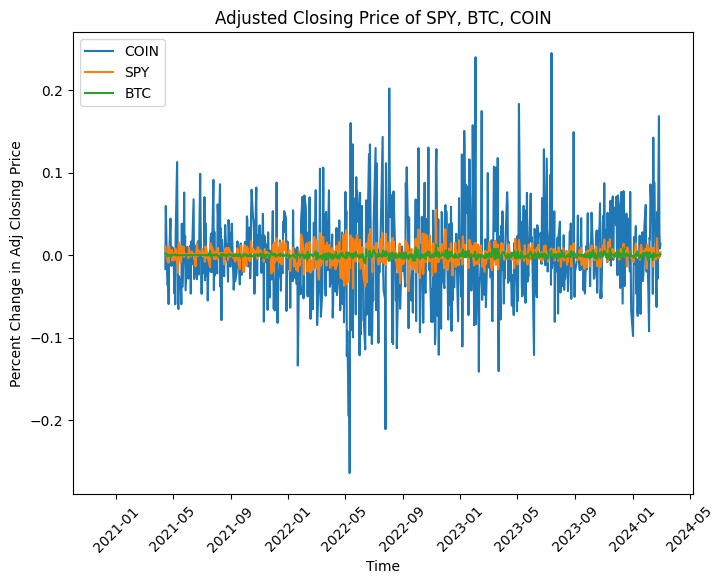

In [455]:
# Returns
returns = crypto_equities.pct_change().dropna()

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(returns['COIN']);
ax.plot(returns['SPY']);
ax.plot(returns['BTC']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
plt.xlim(datetime(2020, 10, 1), date.today());
plt.xticks(rotation = 45);
plt.ylabel('Percent Change in Adj Closing Price');
plt.xlabel('Time')
ax.legend(labels = ['COIN', 'SPY', 'BTC'], loc = 'upper left');

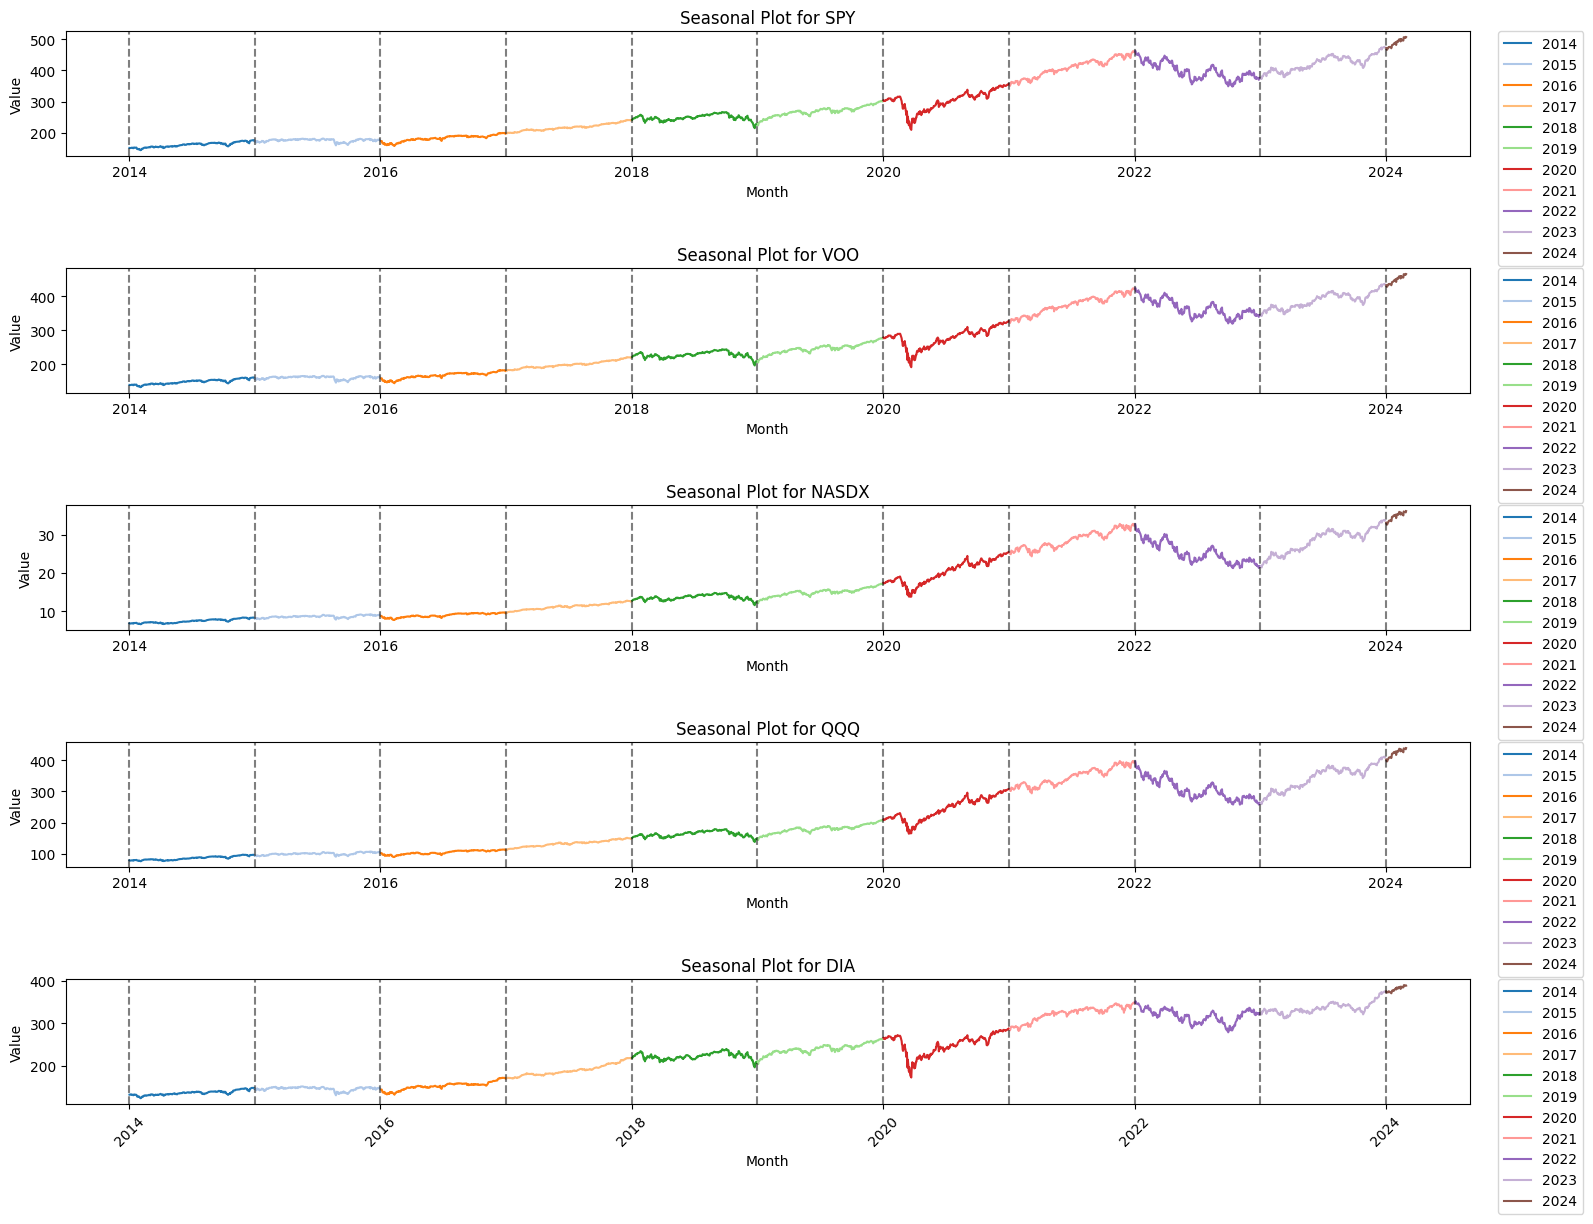

In [456]:
# Seasonal plots for tickers
fig, ax = plt.subplots(NUM_TICKERS, 1, figsize = (16, 12))

for i, ticker in enumerate(tickers):
  seasonal_plot(long_data, ticker, ax=ax[i])
  for year in range(2014, 2025): # add dashed lines for every year
    ax[i].axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.tight_layout()

Other vizs to try: lagplots

Autocorrelation is the correlation between lagged values of a time series. e.g. You can measure the autocorrelation of the price of Bitcoin today and the price 2 days ago.

Important Note: Autocorrelation takes into the account both the indirect and direct effects that the price 2 days ago had on today's price. An example of an indirect effect is the price 2 days ago affected the price 1 day ago which affected the price today.

If we wanted to only measure direct effect we can use the PACF (Partial Autocorrelation Function).

for more info(https://www.youtube.com/watch?v=DeORzP0go5I&t=465s)

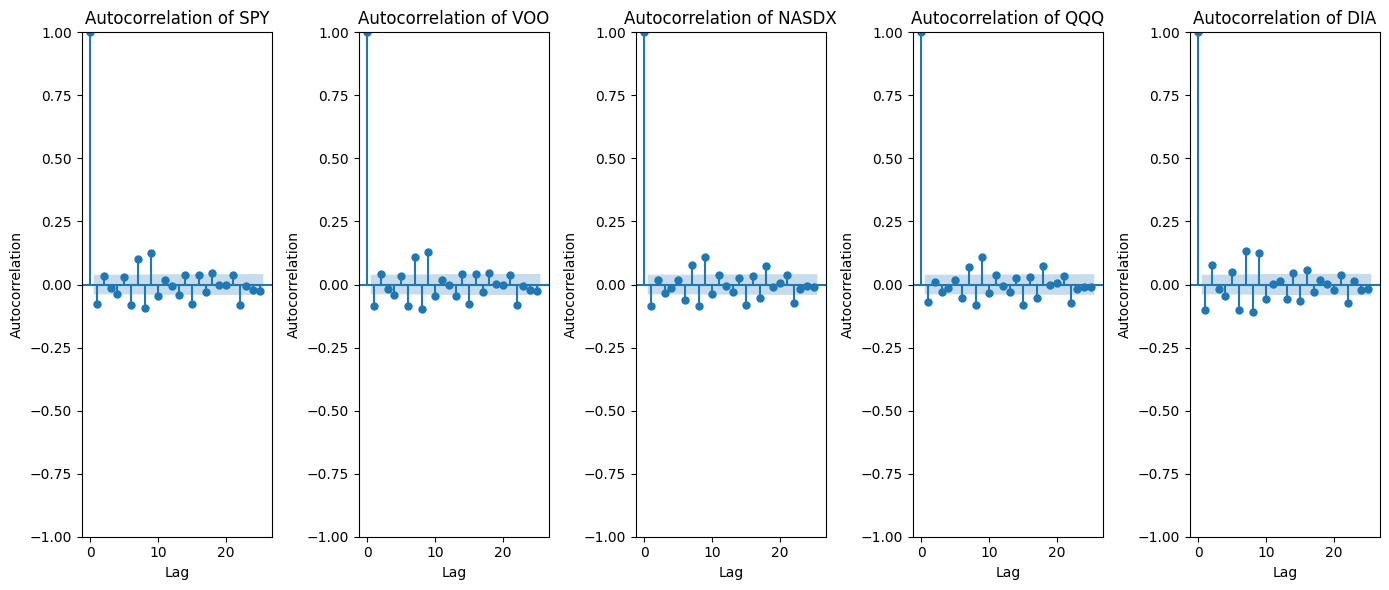

In [457]:
# ACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize=(14, 6))

# first difference makes the data have stationarity so we can create the ACF and PACF plots, which is why we plot the first difference

for i, ticker in enumerate(tickers):
  plot_acf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25) #.diff() calculates the first difference
  ax[i].set(title = f'Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Autocorrelation')

plt.tight_layout()
plt.show()

The ACF plot tells us how correlated today's price is with the kth previous day's price. We are looking for points outside the blue band. Disregard x = 0 because that is the correlation of today's price with itself.

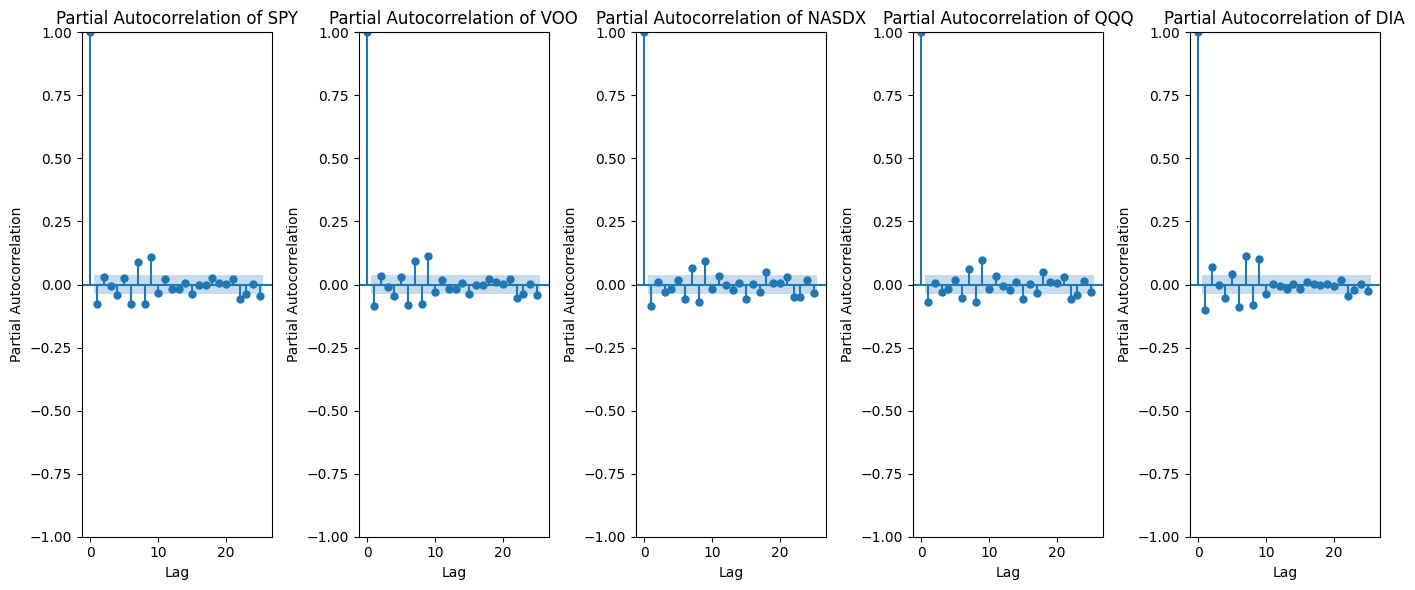

In [458]:
# PACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize= (14, 6))

for i, ticker in enumerate(tickers):
  plot_pacf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25)
  ax[i].set(title = f'Partial Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Partial Autocorrelation')

plt.tight_layout()
plt.show()

Potential PACF values for all tickers
1, 6, 7, 8, 9


In [459]:
PACF_VALUES = [1, 6, 7, 8, 9]
PACF_VALUES_DIA = [1, 2, 4, 6, 7, 8, 9]

Stationary Tests (Dicky-Fuller)

In [460]:
def perform_adf_test(series):
    """Performs Augmented Dicker Fuller Test (stationarity or not)"""
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [461]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: 0.278450
p-value: 0.976334

ADF Test for VOO
ADF Statistic: 0.287264
p-value: 0.976753

ADF Test for NASDX
ADF Statistic: 0.635184
p-value: 0.988451

ADF Test for QQQ
ADF Statistic: 0.634045
p-value: 0.988425

ADF Test for DIA
ADF Statistic: -0.122931
p-value: 0.947106



All time series were not stationary, which is needed for the models we will use. To fix this, we

In [462]:
def transform_data(data, tickers):
    """
    data = pd.Dataframe()
    converts adjusted closing price to first difference to make the data stationary
    """
    for ticker in tickers:
        data[tickers] = data[tickers].diff(periods=1)
    return data.dropna()


In [463]:
transformed_data = data.copy()
transformed_data = transform_data(transformed_data, tickers)

In [464]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(transformed_data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -29.047483
p-value: 0.000000

ADF Test for VOO
ADF Statistic: -29.074977
p-value: 0.000000

ADF Test for NASDX
ADF Statistic: -28.987049
p-value: 0.000000

ADF Test for QQQ
ADF Statistic: -29.074439
p-value: 0.000000

ADF Test for DIA
ADF Statistic: -28.410436
p-value: 0.000000



Splitting Data into Training and Testing

In [465]:
def split_data(data, ticker, train_end, test_end):
    """
    data = pd.Dataframe()
    ticker = ticker symbol
    train_end = the datetime training data should go up to 
    test_end = the datetime the model should forecast until

    returns training_data, testing_data
    """
    ticker_data = data[ticker].copy()
    ticker_data.index = pd.DatetimeIndex(ticker_data.index).to_period('D') # Convert datetime index for proper forecasting

    train_data = ticker_data[:train_end]
    test_data = ticker_data[train_end+timedelta(days=1):test_end]

    return train_data, test_data

In [466]:
train_end = datetime(2023, 2, 1)
test_end = datetime(2023, 2, 8)

In [467]:
spy_train, spy_test = split_data(transformed_data, 'SPY', train_end, test_end)

In [468]:
model = ARIMA(spy_train, order=(9,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                 2282
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -7303.880
Date:                Wed, 08 May 2024   AIC                          14629.760
Time:                        23:07:27   BIC                          14692.821
Sample:                    01-09-2014   HQIC                         14652.760
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.004      0.028      0.978      -0.007       0.007
ar.L1         -2.7984      0.012   -225.145      0.000      -2.823      -2.774
ar.L2         -4.6583      0.036   -129.584      0.0

In [469]:
def undo_transformations(predictions, series):
    """
    Converts our first difference back to original Adj Close Price
    predictions = forecasted values
    series = pd.Series() of original, untransformed, training data
    """
    first_pred = predictions.iloc[0] + series.iloc[-1]
    orig_predictions = [first_pred]

    for i in range(len(predictions[1:])):
        next_pred = predictions.iloc[i+1] + orig_predictions[-1]
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

TODO:
1. Finish evaluate_model()
2. Generate plots with confidence intervals
3. Try MA, ARIMA models

In [470]:
def evaluate_model(fitted_model, testing_data, test_start, test_end, training_data, original_training_data, original_testing_data):
    """
    fitted_model = fitted model object
    testing_data = actual transformed data that we tried to forecast
    test_start = date to start forecasting
    test_end = date to end forecasting
    training_data = transformed training data (to recover transformed predictions)
    original_training_data = pd.Series() of untransformed training data
    original_testing_data = untransformed testing data

    generate predictions of the fitted models using test_data

    returns a datframe of the actual and predicted values
    """
    transformed_predictions = fitted_model.get_prediction(start = test_start, end = test_end) # forecast transformed values
    predictions = undo_transformations(transformed_predictions.predicted_mean, original_training_data) # undo transformations to get forecasted Adj Close Price

    confint = transformed_predictions.conf_int() # converting transformed confidences intervals back to Adj Close Price
    orig_lower_bound = pd.Series(undo_transformations(confint.iloc[:,0], original_training_data), index = confint.index)
    orig_upper_bound = pd.Series(undo_transformations(confint.iloc[:,1], original_training_data), index = confint.index)

    # create a dataframe with 2 columns: actual, predicted 
    df = pd.concat([pd.Series(original_testing_data), pd.Series(predictions, index = transformed_predictions.predicted_mean.index), orig_lower_bound, orig_upper_bound], axis = 1, join = "inner")
    df.columns = ['actual', 'predicted', 'lower_bound', 'upper_bound']

    # ensures both actual and predicted columns are the same shape to do MAE calculations
    print(f"MAE: {mean_absolute_error(df.actual, df.predicted)}")

    return df


In [471]:
test_start_date = spy_test.index[0]
test_end_date = spy_test.index[-1]

In [472]:
og_spy_train, og_spy_test = split_data(data, 'SPY', train_end, test_end)

In [473]:
spy_train.loc[datetime(2020,4,9):]

Date
2020-04-09   -94.283096
2020-04-13    46.863373
2020-04-14     7.514862
2020-04-15   -57.975952
2020-04-16    83.399506
                ...    
2023-01-26   -10.349518
2023-01-27    -9.132629
2023-01-30    16.261566
2023-01-31    14.120728
2023-02-01   -48.214752
Freq: D, Name: SPY, Length: 709, dtype: float64

In [474]:
df = evaluate_model(model_fit, spy_test, test_start_date, test_end_date, spy_train, og_spy_train, og_spy_test)


MAE: 2.561060156967051


In [475]:
df.head()

,actual,predicted,lower_bound,upper_bound
2023-02-02,409.268707,403.396587,344.803957,461.989217
2023-02-03,404.918579,403.396690,286.211430,520.581949
2023-02-06,402.443970,403.396998,110.433849,696.360147
2023-02-07,407.707397,403.397101,51.841322,754.952879
2023-02-08,403.249237,403.397203,-6.751205,813.545612


In [479]:
df.index = df.index.to_timestamp()

In [481]:
og_spy_train.index = og_spy_train.index.to_timestamp()

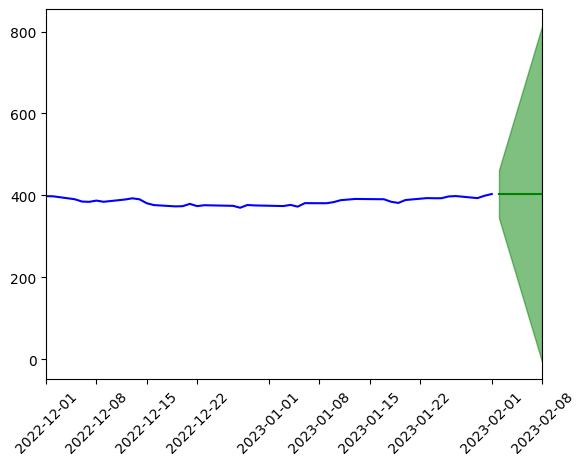

In [504]:
fig, ax = plt.subplots()

ax.plot(og_spy_train, color = 'b')
plt.xlim(datetime(2022, 12, 1), test_end_date);
ax.plot(df.predicted, color = 'g')
plt.fill_between(df.index, df.lower_bound, df.upper_bound, color='g', alpha=0.5)
plt.xticks(rotation = 45);

In [503]:
df.lower_bound

2023-02-02    344.803957
2023-02-03    286.211430
2023-02-06    110.433849
2023-02-07     51.841322
2023-02-08     -6.751205
Freq: B, Name: lower_bound, dtype: float64